In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basic_functions as bf
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore") 

In [2]:
path = '../namesbystate/'
state = 'merged'
full_path = path+state+'.csv'
data_set = pd.read_csv(full_path)

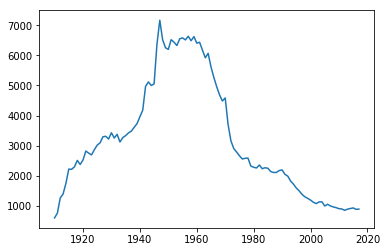

In [108]:
data=bf.get_year("NY","James")
dataM=data[data["Gender"]=="M"]
plt.plot(dataM["Year"],dataM["Occurence"])

In [109]:
#Methode brute pour choisir les paramètres. 

#TODO mais pour l'instant, je fais sans

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Sélection du modèle

In [110]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries["Occurence"].rolling(15).mean()
    rolstd =timeseries["Occurence"].rolling(15).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries["Year"],timeseries["Occurence"], color='blue',label='Original')
    mean = plt.plot(timeseries["Year"],rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries["Year"],rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["Occurence"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput


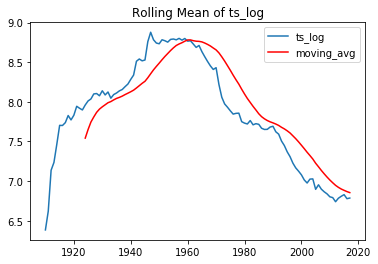

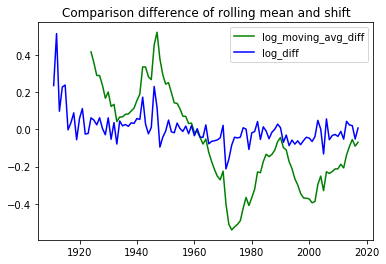

(107, 2)


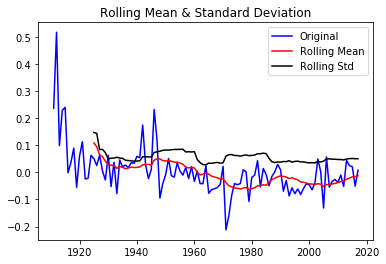

Results of Dickey-Fuller Test:
Test Statistic                  -5.022647
p-value                          0.000020
#Lags Used                       3.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [111]:
ts_log = np.log(dataM["Occurence"])

#Method 1 of removing trend 
moving_avg = ts_log.rolling(15).mean()
plt.plot(dataM["Year"],ts_log,label="ts_log")
plt.plot(dataM["Year"],moving_avg, color='red',label="moving_avg")

plt.title('Rolling Mean of ts_log')
plt.legend(loc='best')
plt.show()

ts_log_moving_avg_diff = ts_log - moving_avg
#ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(dataM["Year"],ts_log_moving_avg_diff, color="green",label="log_moving_avg_diff")


#Method 2 IS BETTER
ts_log_diff = ts_log - ts_log.shift()

plt.plot(dataM["Year"],ts_log_diff, color = 'blue',label="log_diff")
plt.legend(loc='best')
plt.title('Comparison difference of rolling mean and shift')
plt.show()

#Recreate timeseries with result of method 2
new_ts=pd.concat([dataM["Year"],ts_log_diff],axis=1)
new_ts.dropna(inplace=True)
print(new_ts.shape)

result=test_stationarity(new_ts)
if (result["Test Statistic"]>result['Critical Value (1%)']): #and result["Test Statistic"]>result['Critical Value (5%)']): 
#MAIS déjà que c'est moyens, alors si on diminue la confiance de stationnarité, les résultats sont encore moins bons
    raise ValueError("La courbe n'est pas stationnaire !")

#Stationnaire avec confiance de 99%

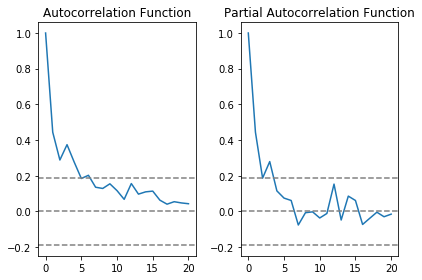

In [112]:
lag_acf = acf(new_ts["Occurence"], nlags=20)
lag_pacf = pacf(new_ts["Occurence"], nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Obtenir p = premier x tel que la courbe coupe l'interval supérieur de confiance
p=0
while lag_acf[p]>1.96/np.sqrt(len(new_ts)) and p<len(lag_acf):
    p+=1

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Obtenir q = premier x tel que la courbe coupe l'interval supérieur de confiance
q=0
while lag_pacf[q]>1.96/np.sqrt(len(new_ts)) and q<len(lag_pacf):
    q+=1

# Training

Chosing p=5 and q=2


Text(0.5,1,'RSS: 0.6206')

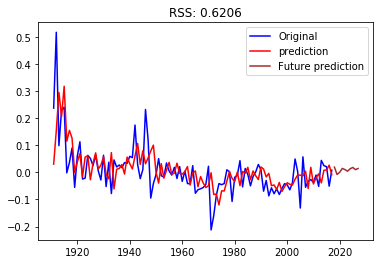

In [113]:
try:
    model = ARIMA(ts_log, order=(p, 1, q))
    results_AR = model.fit(disp=-1) #Seems that it also works without this ? TODO Check
    print ("Chosing p={} and q={}".format(p,q))
except:
    print ("Warning: Chosen p={} and q={} don't work!! Choosing p={} and q={}".format(p,q,p,q-1))
    model = ARIMA(ts_log, order=(p-1, 1, q-1))
    
results_AR = model.fit(disp=-1) #Uses Kalman filter to fit        

#Prédictions futures
forecast_nb=10
forecast_year=[dataM["Year"].iloc[len(dataM["Year"])-1]+i for i in range(1,forecast_nb+1)]
#forecast,stderr,conf_int = results_AR.forecast(steps=forecast_nb)  ====> semble ne pas marcher !!! TODO Pourquoi ????????
forecast2=results_AR.predict(start=len(dataM["Year"]),end=len(dataM["Year"])+forecast_nb-1)
#print(forecast)
#print(forecast2)

new_ts.dropna(inplace=True)
plt.plot(new_ts["Year"],new_ts["Occurence"],label="Original",color='blue')
plt.plot(dataM["Year"][1:],results_AR.fittedvalues, color='red',label="prediction")
#plt.plot(forecast_year,forecast,label="Future prediction",color='green')
plt.plot(forecast_year,forecast2,label="Future prediction",color='brown')
plt.legend(loc="best")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-new_ts["Occurence"])**2))


# Traitement inverse des données

<class 'pandas.core.series.Series'>
1954.3579394581736


Text(0.5,1,'RMSE: nan')

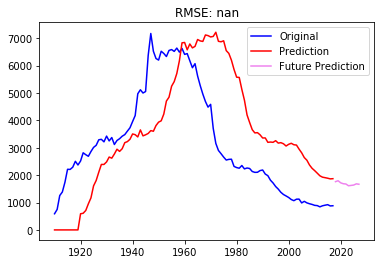

In [114]:
full_prediction = results_AR.fittedvalues.append(forecast2)
print(type(dataM["Year"]))
full_prediction_year = dataM["Year"].append(pd.Series(forecast_year))


#Fait les opérations inverses pour avoir la prédiction avec trend et seasonality
predictions_ARIMA_diff = pd.Series(full_prediction, copy=True)
#print (predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print (predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(dataM["Year"],dataM["Occurence"],color="blue",label="Original")
plt.plot(full_prediction_year[0:len(full_prediction_year)-forecast_nb],predictions_ARIMA[0:len(full_prediction_year)-forecast_nb],color="Red",label="Prediction")
plt.plot(full_prediction_year[len(full_prediction_year)-forecast_nb:],predictions_ARIMA[len(full_prediction_year)-forecast_nb:],color="Violet",label="Future Prediction")
plt.legend(loc="best")

#print(dataM["Occurence"])
#print(predictions_ARIMA[0:len(full_prediction_year)-forecast_nb])
s=0
for i in range(len(dataM["Occurence"])):
    s=s+(dataM["Occurence"].iloc[i]-predictions_ARIMA[0:len(full_prediction_year)-forecast_nb].iloc[i])**2
print(np.sqrt(s/len(dataM["Occurence"])))
#print(sum((predictions_ARIMA[0:len(full_prediction_year)-forecast_nb]-dataM["Occurence"])**2))

#TODO pourquoi calculer RMSE ne marche pas, donne nan ?

plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA[0:len(full_prediction_year)-forecast_nb]-dataM["Occurence"])**2)/len(dataM["Occurence"])))

# Remarques:

Marche plus ou moins bien suivant les prénoms.

Texas:
- John ok
- Lucas ok
- Bob non
- Jaime non

CA:
- John ok
- Sophie non
- Marie bof: tendance, mais courbes éloignées
- Catherine bof: idem :'(

Même si la confiance est de 99% pour la stationnarité, la prédiction n'est pas géniale parfois.

En utilisant ACF et PACF, la plupart du temps, on devrait choisir p=1, q=1, mais ça bugue. Il faut mettre ARIMA(ts_log, order=(2, 1, 2)). J'ai pu mettre 1 et 1 pour Jaime, mais les résultats étaient mauvais.

====> A revérifier parce qu'il y avait un bug

Quand ça suit plus ou moins la tendance, c'est quand même décalé...

## Paramètres à changer éventuellement et autres à faire:
- p et q et d
- time window de 15 années ====> par exemple, valeur trop grande quand c'est un nouveau prénom utilisé que récemment (genre Khaleesi). En même temps, pour ces prénoms, c'est encore plus dur de prédire leur tendance et il y a très peu de chance qu'ils deviennent les prénoms les plus populaires.
=> Et en fait, changer cette valeur ne change pas la conclusion sur la stationnarité ? Donc peut prendre une valeur plus faible ?
- les prénoms et states
- méthodes pour rendre stationnaire car différentiation ne marche pas toujours!!!!!

Vérifier pourquoi results_AR.forecast ne marche pas, mais results_AR.predict marche mieux ? Ce n'est pas censé faire la même chose ?
